# Cargamos las Librerias
1. Numpy
2. Pandas
3. Matplotlib
4. Keras

In [219]:
import os
# Matematicas
import numpy as np
#Datos
import pandas as pd
# Graficos
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import cbook as cbook
# Keras
from keras.layers import Input, Dense, BatchNormalization, Add, GaussianNoise, Dropout
from keras.models import Model
from sklearn.metrics import roc_auc_score
from keras.layers import Wrapper
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras import regularizers
# Normalizacion
from sklearn.preprocessing import StandardScaler

# Cargamos los Datos

In [220]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# Visualizando los Datos

<Figure size 432x288 with 0 Axes>

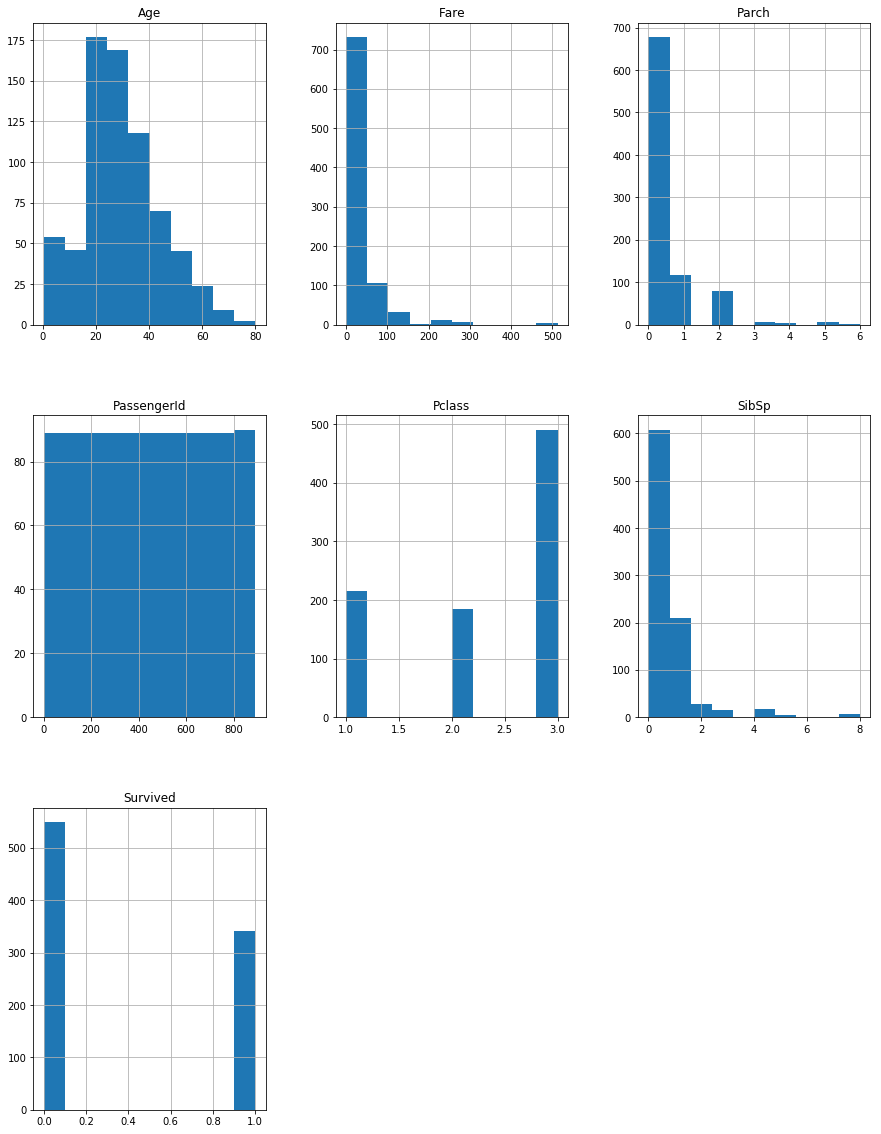

<Figure size 432x288 with 0 Axes>

In [221]:
train_df.hist(figsize = (15,20))
plt.figure()

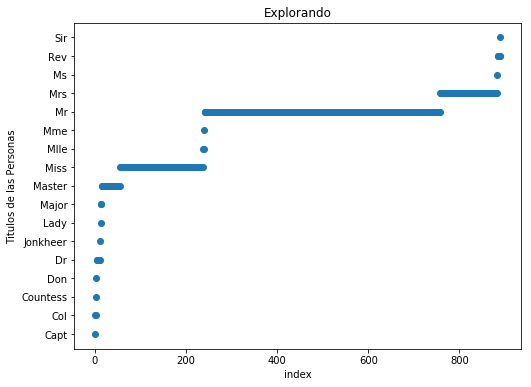

In [222]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False).values))
plt.xlabel('index')
plt.ylabel('Titulos de las Personas')
plt.title('Explorando')
plt.show()

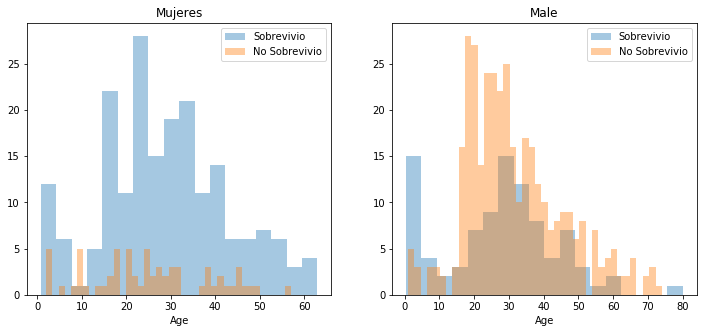

In [223]:
survived = 'Sobrevivio'
not_survived = 'No Sobrevivio'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']
women_1 = women[women['Survived'] == 1]['Age'].dropna()
women_0 = women[women['Survived'] == 0]['Age'].dropna()
men_1 = men[men['Survived'] == 1]['Age'].dropna()
men_0 = men[men['Survived'] == 0]['Age'].dropna()

ax = sns.distplot(women_1, bins=18, label = survived, ax = axes[0], kde = False)
ax = sns.distplot(women_0, bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Mujeres')

ax = sns.distplot(men_1, bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men_0, bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax = ax.set_title('Male')

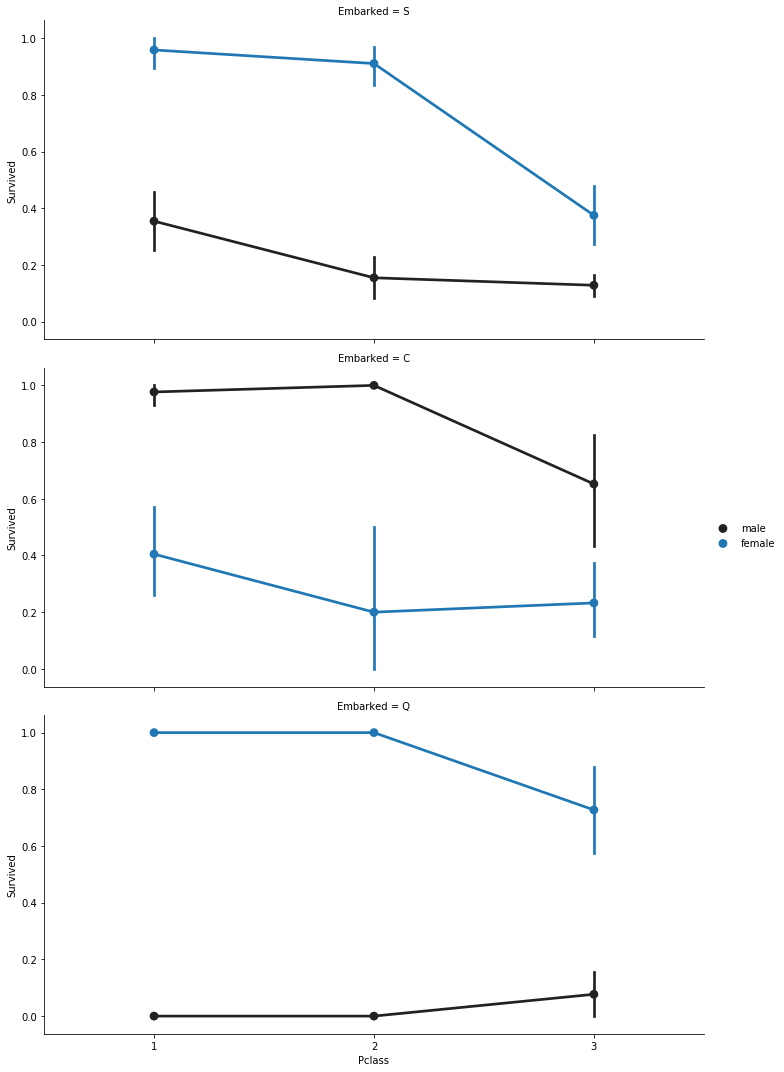

In [224]:
FacetGrid = sns.FacetGrid(train_df, row = 'Embarked', height = 5, aspect = 2)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = None, order = None, hue_order = None)
FacetGrid.add_legend() 

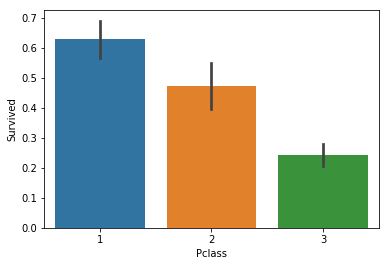

In [225]:
sns.barplot(x = 'Pclass', y = 'Survived', data = train_df)

In [226]:
sets = [train_df, test_df]
for _set in sets:
    _set['Relatives'] = _set['SibSp'] + _set['Parch']
    _set.loc[_set['Relatives'] > 0, 'not_alone'] = 0
    _set.loc[_set['Relatives'] == 0, 'not_alone'] = 1
    _set['not_alone'] = _set['not_alone'].astype(int)
print(train_df['not_alone'].value_counts())

1    537
0    354
Name: not_alone, dtype: int64


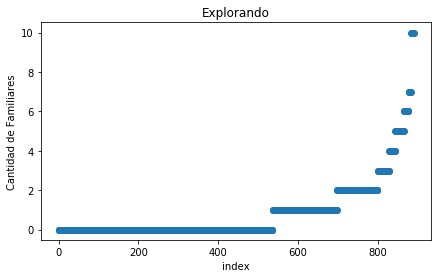

In [227]:
plt.figure(figsize=(7,4))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['Relatives'].values))
plt.xlabel('index')
plt.ylabel('Cantidad de Familiares')
plt.title('Explorando')
plt.show()

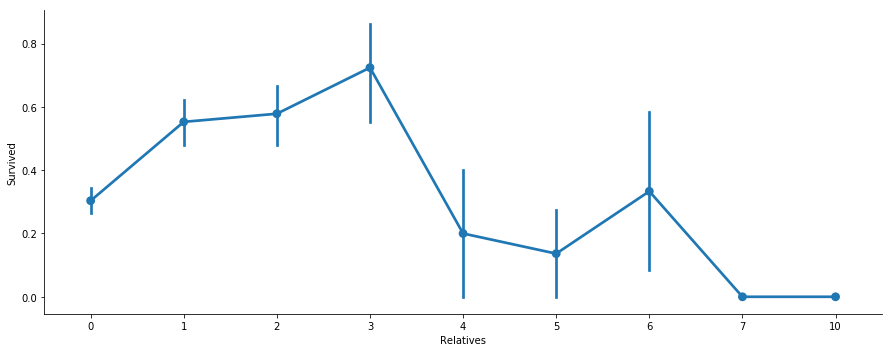

In [228]:
axes = sns.catplot('Relatives','Survived', data = train_df, kind = 'point', aspect = 2.5, )

<Figure size 432x288 with 0 Axes>

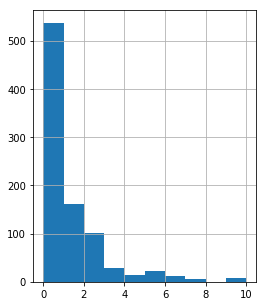

<Figure size 432x288 with 0 Axes>

In [229]:
train_df['Relatives'].hist(figsize = (4, 5))
plt.figure()

# Limpiamos los Datos

Durante este proceso se limpian los datos de los data sets, ademas se rellenan los datos faltantes considerando la media y su desviacion, o el dato mas comun.


In [230]:
# Borramos los ids esto no funciona para el modelo
train_df = train_df.drop(['PassengerId'], axis=1)
test_df = test_df.drop(['PassengerId'], axis=1)

In [231]:
np.random.seed(1)
embarked_common = train_df['Embarked'].describe().values[2] # tomamos el valor mas comun de 'Embarked'
# Calculamos la media y la desviacion de la edad segun el sexo
women_avg = train_df[train_df['Sex'] == 'female']['Age'].mean()
women_std = train_df[train_df['Sex'] == 'female']['Age'].std()
men_avg = train_df[train_df['Sex'] == 'male']['Age'].mean()
men_std = train_df[train_df['Sex'] == 'male']['Age'].std()
# Corregir la edad
for i in range(len(train_df['Sex'].values)):
    if np.isnan(train_df['Age'].values[i]):
        if train_df['Sex'].values[i] == 'female':
            train_df['Age'].values[i] = np.random.randint(women_avg - women_std, women_avg + women_std)
        else:
            train_df['Age'].values[i] = np.random.randint(men_avg - men_std, men_avg + men_std)
for i in range(len(test_df['Sex'].values)):
    if np.isnan(test_df['Age'].values[i]):
        if test_df['Sex'].values[i] == 'female':
            test_df['Age'].values[i] = np.random.randint(women_avg - women_std, women_avg + women_std)
        else:
            test_df['Age'].values[i] = np.random.randint(men_avg - men_std, men_avg + men_std)

sets = [train_df, test_df]

for _set in sets:
    _set['Title'] = _set['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    _set['Embarked'] = _set['Embarked'].fillna(embarked_common)
    _set['Title'] = _set['Title'].replace(['Don', 'Rev', 'Dr', 'Capt', 'Col', 'Major'], 'Mr')
    _set['Title'] = _set['Title'].replace(['Mlle', 'Ms'], 'Miss')
    _set['Title'] = _set['Title'].replace('Mme', 'Mrs')
    _set['Title'] = _set['Title'].replace(['Lady', 'Sir', 'Countess'], 'Royal')
    _set['Title'] = _set['Title'].replace(['Dona', 'Jonkheer'], 'Others')
    # Vamos a convertir categorias en valores numericos para la red
    gender = { "female": 0, "male": 1 }
    ports = {"S": 0, "C": 1, "Q": 2}
    # Senor, joven, Senorita, Senora, Realeza, Otros
    titles = { "Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Royal": 5, "Others": 6 }
    cabins = { 'N': 0, 'C': 1, 'E': 2, 'G': 3, 'D': 4, 'A': 5, 'B': 6, 'F': 8, 'T': 9 }
    _set['Sex'] = _set['Sex'].map(gender)
    _set['Embarked'] = _set['Embarked'].map(ports)
    _set['Title'] = _set['Title'].map(titles)
    _set['Title'] = _set['Title'].fillna(0)
    _set['Cabin'] = _set['Cabin'].fillna('N/A')
    _set['Cabin'] = _set['Cabin'].apply(lambda x: x[0])
    _set['Cabin'] = _set['Cabin'].map(cabins)
    _set['Age'] = _set['Age'].astype(int)
    _set['Fare'] = _set['Fare'].fillna(0)
    _set['Fare'] = _set['Fare'].astype(int)

In [232]:
train_df = train_df.drop(columns=['Name', 'SibSp', 'Parch', 'not_alone', 'Ticket'], axis=1)
test_df  =  test_df.drop(columns=['Name', 'SibSp', 'Parch', 'not_alone', 'Ticket'], axis=1)

In [233]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int64
Age          891 non-null int64
Fare         891 non-null int64
Cabin        891 non-null int64
Embarked     891 non-null int64
Relatives    891 non-null int64
Title        891 non-null int64
dtypes: int64(9)
memory usage: 62.7 KB


In [204]:
def model():
    

array([0, 1, 2, 3, 4, 5, 6, 8, 9])